# 3D модель симулируемой системы
В данном блокноте с помощью библиотеки `plotly` представлена интерактивная 3D модель изучаемой системы для модели `rfid`. На ней схематично изображён БПЛА с RFID считывателем (точка) в воздухе и RFID метка (другая точка) на земле. Прямой и отражённый луч, а также диаграммы направленности антенн рассматриваемых устройств изображены в качетсве векторов.

Полученная визуализация не связана зависимостями с моделью `rfid` или с расчётом канала. Она служит наглядной документацией для кода и материала кандидатской диссертации

In [1]:
import numpy as np
import plotly.graph_objects as go

## Параметры исследуемой системы
В данной визуализации есть следующие допущения:
* В блокноте для удобства описания под передатчиком понимается RFID считыватель, а под приёмником - RFID метка. В общем случае это неверно, так как в разные моменты времени и считыватель, и метка поочерёдно выступают в качестве и передатчика, и приёмника. При этом все алгебраические и геометрические вычисления, приведённые здесь эквивалентны и работают в обе стороны;
* Визуализация представлена в трёхмерных декартовых координатах;
* Визуализация не связана зависимостями от других модулей, благодаря чему можно легко менять параметры и наблюдать за изменениями взаимного расположения считывателя и метки;
* Основными параметрами для визуализируемой системы являются: положение RFID считывателя `(x, y, z)`, положение RFID метки `(x, y, z)`, положение стены (плоскости), от которой происходит отражение сигнала. Все остальные параметры математически зависят от этих трёх;
* Подразумевается, что метка неподвижна, а считыватель движется вдоль оси OY;
* Антенна считывателя всегда направлена строго вниз;
* Антенна метки всегда направлена строго вверх;
* Плоскость задаётся с помощью координат нормального к ней вектора и точки;
* LoS - Line-of-Sight, прямой луч;
* NLoS - Non-Line-of-Sight, отражённый луч идущий до "зазеркальной" метки.

### Основные параметры

In [6]:
TX_POS = np.array([2, 0, 5]) # Координаты передатчика (считыватель)
RX_POS = np.array([2, -10, 0]) # Координаты приёмника (метка)
WALL_NORMAL = np.array([1, 0, 0]) # Нормаль к стене, от которой происходит отражение
WALL_POINT = np.array([0, 0, 0]) # Координаты случайной точки на стене

### Зависимые от основных параметры

In [7]:
tx_antenna_dir = TX_POS + np.array([0, 0, -1]) # Направление антенны считывателя
rx_antenna_dir = RX_POS + np.array([0, 0, 1]) # Направление антенны метки

rx_pos_refl = np.array([-RX_POS[0], RX_POS[1], RX_POS[2]]) # "Зазеркальный" приёмник

d0_vector = RX_POS - TX_POS  # LoS
d1_vector = rx_pos_refl - TX_POS  # NLoS
d0 = np.linalg.norm(d0_vector)  # Длина LoS
d1 = np.linalg.norm(d1_vector)  # Длина NLoS

d0_vector_tx_n = d0_vector / d0  # LoS нормализованный
d0_vector_rx_n = -d0_vector_tx_n # Минус для того, чтобы получить из смежного искомый угол
d1_vector_tx_n = d1_vector / d1  # NLoS нормализованный
d1_vector_rx_n = np.array([-d1_vector_tx_n[0], d1_vector_tx_n[1], d1_vector_tx_n[2]]) # Продолженный реальный отражённый луч

# Из планиметрических соображений вычисление координат точки пересечения отражённого луча
# со стеной (плоскостью)
x_rfp = 0 # Так как стена находится на плоскости YOZ
y_rfp = -TX_POS[0] * (rx_pos_refl[1] - TX_POS[1]) / (rx_pos_refl[0] - TX_POS[0]) + TX_POS[1]
z_rfp = -TX_POS[0] * (rx_pos_refl[2] - TX_POS[2]) / (rx_pos_refl[0] - TX_POS[0]) + TX_POS[2]
ref_point = np.array([x_rfp, y_rfp, z_rfp])

## Функции для создания визуализации

In [8]:
def plot_vector(fig, start, end, color="red", name=None):
    """
    Построить вектор.

    Args:
        fig: объект plotly.graph_objects
        start (np.array(x,y,z)): координаты начала вектора
        end (np.array(x,y,z)): координаты конца вектора
        color (str): цвет линии вектора
        name (None|str): имя вектора для легенды
    
    """
    vector = np.array(end) - np.array(start)
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode="lines+markers",
        line=dict(color=color, width=5),
        marker=dict(size=4),
        name=name or f"Vector {vector}"
    ))

def plot_point(fig, point, color="blue", name=None):
    """
    Построить точку.

    Args:
        fig: объект plotly.graph_objects
        point (np.array(x,y,z)): координаты точки
        color (str): цвет точки
        name (None|str): имя точки для легенды
    
    """
    fig.add_trace(go.Scatter3d(
        x=[point[0]], y=[point[1]], z=[point[2]],
        mode="markers",
        marker=dict(size=6, color=color),
        name=name or f"Point {point}"
    ))

def plot_plane(fig, normal, point_on_plane, size=10, color="lightblue", opacity=0.5):
    """
    Построить плоскость.

    Args:
        fig: объект plotly.graph_objects
        normal (np.array(x,y,z)): координаты нормального к плоскости вектора
        point_on_plane (np.array(x,y,z)): точка на плоскости
        size (int): размеры плоскости (size x size)
        color (str): цвет плоскости
        opacity (float): прозрачность плоскости
    """
    normal = np.array(normal)
    point = np.array(point_on_plane)

    d = -np.dot(normal, point)

    # Определим, какую координату выразим
    a, b, c = normal
    grid_pts = np.linspace(-size, size, 10)

    if abs(c) > 1e-6:
        X, Y = np.meshgrid(grid_pts, grid_pts)
        Z = (-a * X - b * Y - d) / c
    elif abs(b) > 1e-6:
        X, Z = np.meshgrid(grid_pts, grid_pts)
        Y = (-a * X - c * Z - d) / b
    elif abs(a) > 1e-6:
        Y, Z = np.meshgrid(grid_pts, grid_pts)
        X = (-b * Y - c * Z - d) / a
    else:
        raise ValueError("Недопустимая нормаль: нормаль не должна быть нулевым вектором.")

    fig.add_trace(go.Surface(
        x=X, y=Y, z=Z,
        opacity=opacity,
        colorscale=[[0, color], [1, color]],
        showscale=False
    ))

def draw_axes(fig, length=10):
    """
    Построить оси OX, OY, OZ.

    Args:
        fig: объект plotly.graph_objects
        length (int): длина осей
    """
    fig.add_trace(go.Scatter3d(x=[-length, length], y=[0, 0], z=[0, 0], mode="lines", line=dict(width=8, color="black"), name="OX"))
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[-length, length], z=[0, 0], mode="lines", line=dict(width=8, color="black"), name="OY"))
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[-length, length], mode="lines", line=dict(width=8, color="black"), name="OZ"))

    # Стрелки
    fig.add_trace(go.Cone(
        x=[length], y=[0], z=[0], u=[1], v=[0], w=[0], sizemode="absolute", sizeref=2, anchor="tail", showscale=False, colorscale=[[0, "black"], [1, "black"]]))
    fig.add_trace(go.Cone(
        x=[0], y=[length], z=[0], u=[0], v=[1], w=[0], sizemode="absolute", sizeref=2, anchor="tail", showscale=False, colorscale=[[0, "black"], [1, "black"]]))
    fig.add_trace(go.Cone(
        x=[0], y=[0], z=[length], u=[0], v=[0], w=[1], sizemode="absolute", sizeref=2, anchor="tail", showscale=False, colorscale=[[0, "black"], [1, "black"]]))

    # Подписи
    fig.add_trace(go.Scatter3d(x=[length + 1], y=[0], z=[0], mode="text", text=["X"], textposition="top right", name="", showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0], y=[length + 1], z=[0], mode="text", text=["Y"], textposition="top right", name="", showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[length + 1], mode="text", text=["Z"], textposition="top right", name="", showlegend=False))

## Построить визуализацию
* Коричневая плоскость XOY - земля
* Зелёная плоскость YOZ - стена, от которой происходит отражение луча

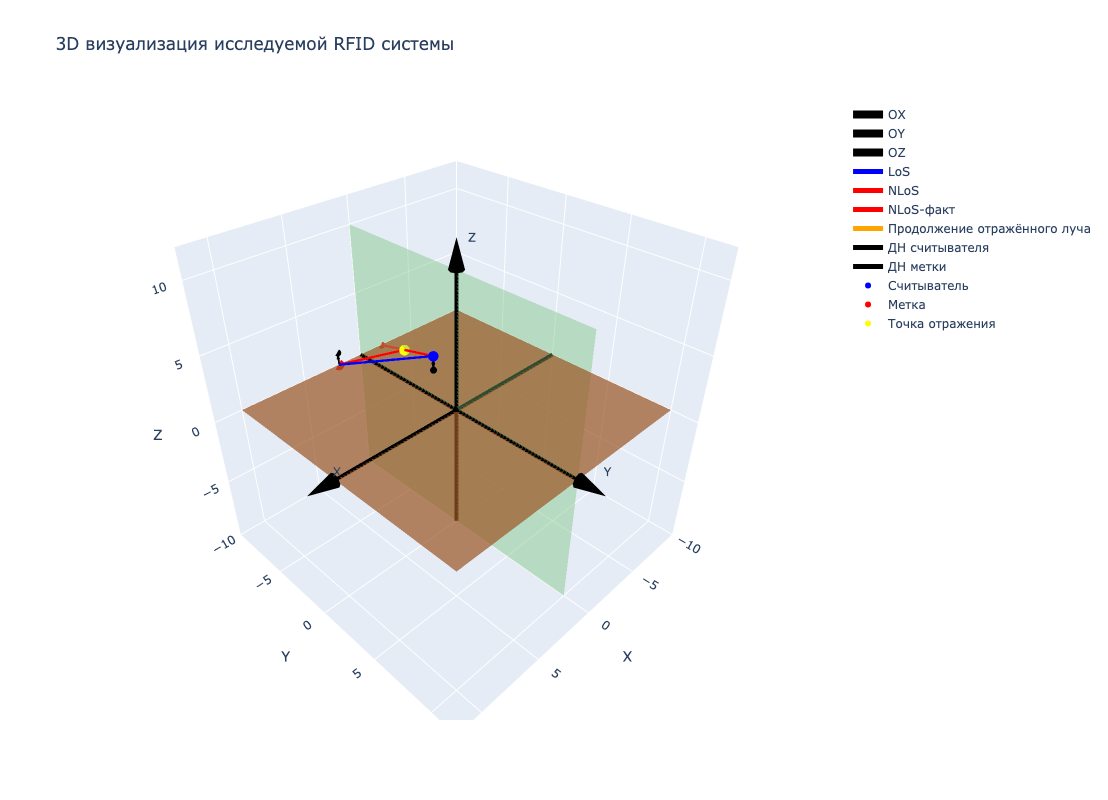

In [9]:
fig = go.Figure()

draw_axes(fig)

# Векторы ----------------------------------------------------------------
plot_vector(fig, TX_POS, RX_POS, color="blue", name="LoS") # Прямая компонента сигнала
plot_vector(fig, TX_POS, rx_pos_refl, color="red", name="NLoS") # Компонента до "зазеркальной" метки
plot_vector(fig, ref_point, RX_POS, color="red", name="NLoS-факт") # Реальная отражённая компонента
plot_vector(fig, RX_POS, RX_POS + d1_vector_rx_n, color="orange", name="Продолжение отражённого луча") # Вспомогательный вектор для вычисления угла между ДН метки и отражённым от стены лучом
plot_vector(fig, TX_POS, tx_antenna_dir, color="black", name="ДН считывателя")
fig.add_trace(go.Cone(
    x=[tx_antenna_dir[0]], y=[tx_antenna_dir[1]], z=[tx_antenna_dir[2]],
    u=[0], v=[0], w=[-1],
    sizemode="absolute", sizeref=0.5, anchor="tip", showscale=False,
    colorscale=[[0, "black"], [1, "black"]],
    name="Arrow TX"
))
plot_vector(fig, RX_POS, rx_antenna_dir, color="black", name="ДН метки")
fig.add_trace(go.Cone(
    x=[rx_antenna_dir[0]], y=[rx_antenna_dir[1]], z=[rx_antenna_dir[2]],
    u=[0], v=[0], w=[1],
    sizemode="absolute", sizeref=0.5, anchor="tip", showscale=False,
    colorscale=[[0, "black"], [1, "black"]],
    name="Arrow RX"
))

# Точки ------------------------------------------------------------------
plot_point(fig, TX_POS, color="blue", name="Считыватель")
plot_point(fig, RX_POS, color="red", name="Метка")
plot_point(fig, ref_point, color="yellow", name="Точка отражения")

# Плоскости ------------------------------------------------------------------
plot_plane(fig, WALL_NORMAL, WALL_POINT, size=10, color="lightgreen", opacity=0.4) # Плоскость YOZ от которой происходит отражение
plot_plane(fig, np.array([0, 0, 1]), np.array([0, 0, 0]), size=10, color="saddlebrown", opacity=0.7)

fig.update_layout(
    scene=dict(
        xaxis=dict(title="X", range=[-10, 12]),
        yaxis=dict(title="Y", range=[-10, 12]),
        zaxis=dict(title="Z", range=[-10, 12]),
        aspectmode="cube"
    ),
    width=1000,
    height=800,
    title="3D визуализация исследуемой RFID системы"
)

fig.show()
